## Question 1
* List price is max price sold to a distributor, but does not indicate that the distributor paid this price
* A product has multiple list prices, try to determine which other fields are correlated/cause the list price to change. For a given time period (2012-01-01 to 2013-01-01) where the 5 ListPrices are constant, which variables determine a change between the 5 values
* Horizontal stripe plot
    * this is plot of list price over time for a single product
    * the product can have multiple list prices simultaneously
    * looks like the product has 5 values of list price it can take at any given time, there are 2 instances in the plot where all 5 of these values are increased at the same time
    * some of the values for list price are set very infrequently, appearing as dots instead of horizontal lines
    * maybe the infrequent values only set for times when product in high demand due to season or maybe when particular distributors buy it who only buy seasonally

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .master("local[1]") \
    .appName("test") \
    .getOrCreate()

def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/04 20:56:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [79]:
df = spark.read.option('header', True).option("delimiter", "\t").csv("case-merged-invoices-2012.csv")

float_vars = ['UnitPrice', 'Multiplier', 'Discount', 'ListPrice', 'ExtendedCost', 'Cost', 'Revenue', 'Volume']

# https://stackoverflow.com/questions/30580410/how-to-do-labelencoding-or-categorical-value-in-apache-spark
categorical_vars = ['QuoteTypeKey', 'CustId', 'flag1', 'CustomerNumber', 'CustomerChannel', 'SalesPersonName', 'region']

df = df.withColumn('InvoiceDate', F.to_date(F.col("InvoiceDate"), "yyyy-MM-dd"))

for v in float_vars:
    df = df.withColumn(v, F.col(v).cast("float"))

In [77]:
from pyspark.sql import types

dates = ("2012-01-01",  "2013-01-01")
date_from, date_to = [F.to_date(F.lit(s)).cast(types.DateType()) for s in dates]

filter_df = df.where((F.col('InvoiceDate') >= date_from) & (F.col('InvoiceDate') < date_to))
filter_df = filter_df.filter(F.col('ProdId') == '528')

In [78]:
pd_df = filter_df.toPandas()

In [46]:
pd_df = pd_df.sort_values('InvoiceDate')

<Axes: xlabel='InvoiceDate'>

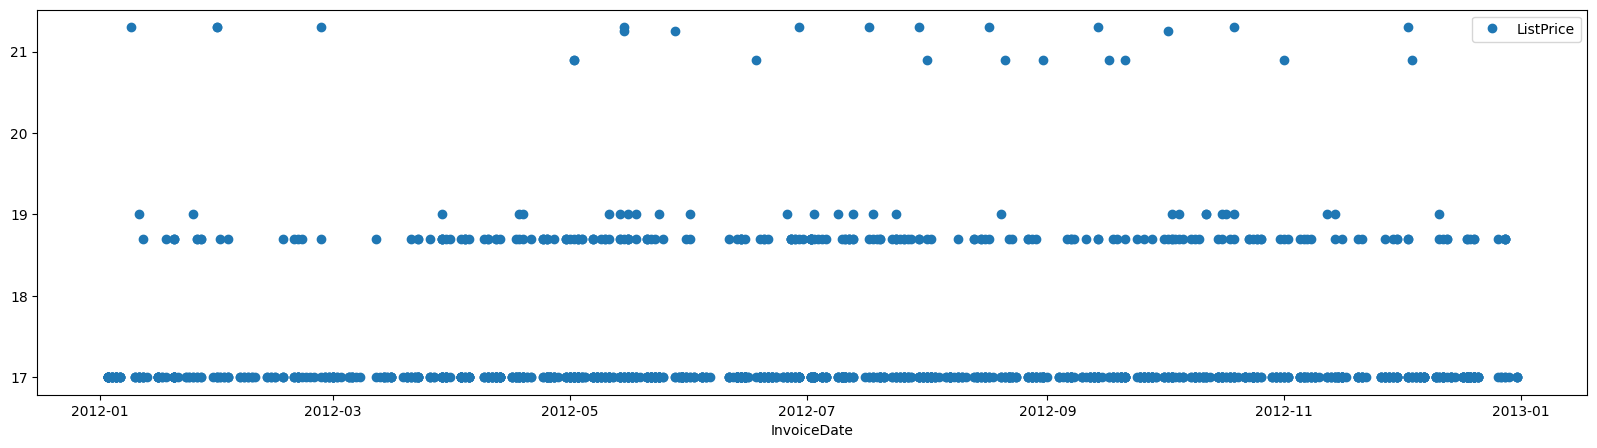

In [47]:
pd_df.plot(x='InvoiceDate', y='ListPrice', style='o', figsize=(20,5))

In [54]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
for column in categorical_vars:
    pd_df[column] = labelencoder.fit_transform(pd_df[column])

filter_pd_df = pd_df[float_vars + categorical_vars]

In [55]:
# https://datascience.stackexchange.com/questions/39137/how-can-i-check-the-correlation-between-features-and-target-variable
filter_pd_df.corr()['ListPrice'][:]

UnitPrice          0.603058
Multiplier        -0.040837
Discount           0.040837
ListPrice          1.000000
ExtendedCost      -0.110689
Cost              -0.068934
Revenue           -0.098755
Volume            -0.112537
QuoteTypeKey       0.025306
CustId             0.035799
flag1              0.203412
CustomerNumber    -0.080925
CustomerChannel   -0.054337
SalesPersonName   -0.097128
region            -0.097587
Name: ListPrice, dtype: float64

In [72]:
norm_pd_df = filter_pd_df.copy()
float_vars.remove('ListPrice')
norm_pd_df[float_vars] = norm_pd_df[float_vars].apply(lambda x: (x - x.mean()) / x.std())


unique_list_prices = norm_pd_df['ListPrice'].unique()
num_vars = {}
num_means = {}
cat_pcts = {}
for price in unique_list_prices:
    num_df = norm_pd_df.loc[norm_pd_df['ListPrice'] == price][float_vars]
    cat_df = norm_pd_df.loc[norm_pd_df['ListPrice'] == price][categorical_vars]
    num_vars[price] = num_df.var()
    num_means[price] = num_df.mean(axis=0)
    
    counts = []
    for v in categorical_vars:
         counts.append(cat_df[v].value_counts(normalize=True))
    cat_pcts[price] = counts

float_vars.append('ListPrice')


In [67]:
num_vars

{17.0: UnitPrice       0.525731
 Multiplier      0.881270
 Discount        0.881270
 ExtendedCost    1.106198
 Cost            1.210562
 Revenue         1.074239
 Volume          1.095578
 dtype: float32,
 21.3: UnitPrice       0.353806
 Multiplier      0.377790
 Discount        0.377790
 ExtendedCost    0.008171
 Cost            0.026449
 Revenue         0.014827
 Volume          0.009282
 dtype: float32,
 19.0: UnitPrice       5.731218
 Multiplier      7.691006
 Discount        7.691005
 ExtendedCost    3.530389
 Cost            0.041196
 Revenue         4.842541
 Volume          3.863584
 dtype: float32,
 18.7: UnitPrice       0.516578
 Multiplier      0.715642
 Discount        0.715642
 ExtendedCost    0.021578
 Cost            0.033199
 Revenue         0.029014
 Volume          0.024440
 dtype: float32,
 20.9: UnitPrice       1.073005
 Multiplier      1.190016
 Discount        1.190015
 ExtendedCost    0.012956
 Cost            0.056424
 Revenue         0.021884
 Volume          0

In [68]:
num_means

{17.0: UnitPrice      -0.265510
 Multiplier      0.018012
 Discount       -0.018012
 ExtendedCost    0.057297
 Cost            0.035163
 Revenue         0.052039
 Volume          0.058290
 dtype: float32,
 21.3: UnitPrice       3.132284
 Multiplier      0.049991
 Discount       -0.049992
 ExtendedCost   -0.342986
 Cost           -0.177554
 Revenue        -0.298647
 Volume         -0.352076
 dtype: float32,
 19.0: UnitPrice       0.351923
 Multiplier     -1.080804
 Discount        1.080803
 ExtendedCost    0.552016
 Cost           -0.134652
 Revenue         0.663831
 Volume          0.592064
 dtype: float32,
 18.7: UnitPrice       1.090859
 Multiplier      0.047777
 Discount       -0.047778
 ExtendedCost   -0.350324
 Cost           -0.159235
 Revenue        -0.340613
 Volume         -0.360015
 dtype: float32,
 20.9: UnitPrice       2.495641
 Multiplier     -0.290025
 Discount        0.290024
 ExtendedCost   -0.342693
 Cost           -0.111828
 Revenue        -0.309635
 Volume         -0

In [73]:
cat_pcts

{17.0: [QuoteTypeKey
  1    0.811195
  2    0.127820
  0    0.058480
  3    0.002506
  Name: proportion, dtype: float64,
  CustId
  451    0.034252
  377    0.033417
  297    0.019215
  20     0.019215
  232    0.015873
           ...   
  71     0.000835
  249    0.000835
  246    0.000835
  40     0.000835
  106    0.000835
  Name: proportion, Length: 290, dtype: float64,
  flag1
  0    0.827903
  8    0.089390
  5    0.082707
  Name: proportion, dtype: float64,
  CustomerNumber
  301    0.034252
  38     0.033417
  405    0.019215
  260    0.019215
  347    0.015873
           ...   
  326    0.000835
  204    0.000835
  331    0.000835
  315    0.000835
  106    0.000835
  Name: proportion, Length: 290, dtype: float64,
  CustomerChannel
  5    0.367586
  1    0.324979
  6    0.139515
  4    0.075188
  2    0.050961
  3    0.035088
  0    0.006683
  Name: proportion, dtype: float64,
  SalesPersonName
  103    0.058480
  53     0.037594
  49     0.035088
  100    0.034252
  70     0.

In [74]:
filter_pd_df['flag1'].value_counts()

flag1
0    991
1    166
8    107
5     99
6     50
2     28
4     12
3     10
7      3
Name: count, dtype: int64

## Question 2
* Discount is `1 - (UnitPrice / ListPrice)` with `UnitPrice = Revenue / Volume`
* Determine which variables explain variance in Discount
* Plot 1
    * each row in dataframe is an invoice that has revenue and discount features among others
    * shows a plot of all (revenue, discount) pairs for a month
    * for invoices with high revenue, there is low variance in discounts applied. invoices with low revenue have high variance in discounts applied
* Plot 2
    * shows that most invoices have 0 discount, otherwise discounts get less frequent as discount rate goes up

In [16]:
df = spark.read.option('header', True).option("delimiter", "\t").csv("case-merged-invoices-2012.csv")

float_vars = ['UnitPrice', 'Multiplier', 'Discount', 'ListPrice', 'ExtendedCost', 'Cost', 'Revenue', 'Volume']
categorical_vars = ['QuoteTypeKey', 'CustId', 'flag1', 'CustomerNumber', 'CustomerChannel', 'SalesPersonName', \
                    'region', 'ProdId', 'InvoiceDate', 'ProductFamily', 'Style', 'LED', 'Commodity', 'EnergyEfficient']

for v in float_vars:
    df = df.withColumn(v, F.col(v).cast("float"))

In [17]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

df = df.drop('Discount', 'UnitPrice')
df = df.withColumn('UnitPrice', F.col('Revenue') / F.col('Volume'))
df = df.withColumn('Discount', 1 - (F.col('UnitPrice') / F.col('ListPrice')))

indexer = [StringIndexer(inputCol=col, outputCol=col + "_ordinal") for col in categorical_vars]
pipeline = Pipeline(stages=indexer)
indexer_model = pipeline.fit(df)
q2_df = indexer_model.transform(df)

In [18]:
all_vars = float_vars + [f'{c}_ordinal' for c in categorical_vars]
corr_df = q2_df.select(*all_vars)
corr_pd = corr_df.toPandas()

In [19]:
corr_pd = corr_pd.replace([np.inf, -np.inf], np.nan)
corr_pd.dropna(inplace=True)

In [20]:
corr_pd.corr()['Discount'][:]

UnitPrice                 -0.194147
Multiplier                -1.000000
Discount                   1.000000
ListPrice                  0.310991
ExtendedCost               0.093668
Cost                       0.179354
Revenue                   -0.090057
Volume                     0.069218
QuoteTypeKey_ordinal       0.354966
CustId_ordinal            -0.077663
flag1_ordinal              0.004402
CustomerNumber_ordinal    -0.077488
CustomerChannel_ordinal    0.042864
SalesPersonName_ordinal   -0.022000
region_ordinal             0.010804
ProdId_ordinal            -0.039099
InvoiceDate_ordinal        0.004279
ProductFamily_ordinal      0.053354
Style_ordinal              0.039459
LED_ordinal               -0.018586
Commodity_ordinal          0.005431
EnergyEfficient_ordinal    0.033417
Name: Discount, dtype: float64

<Axes: xlabel='QuoteTypeKey_ordinal'>

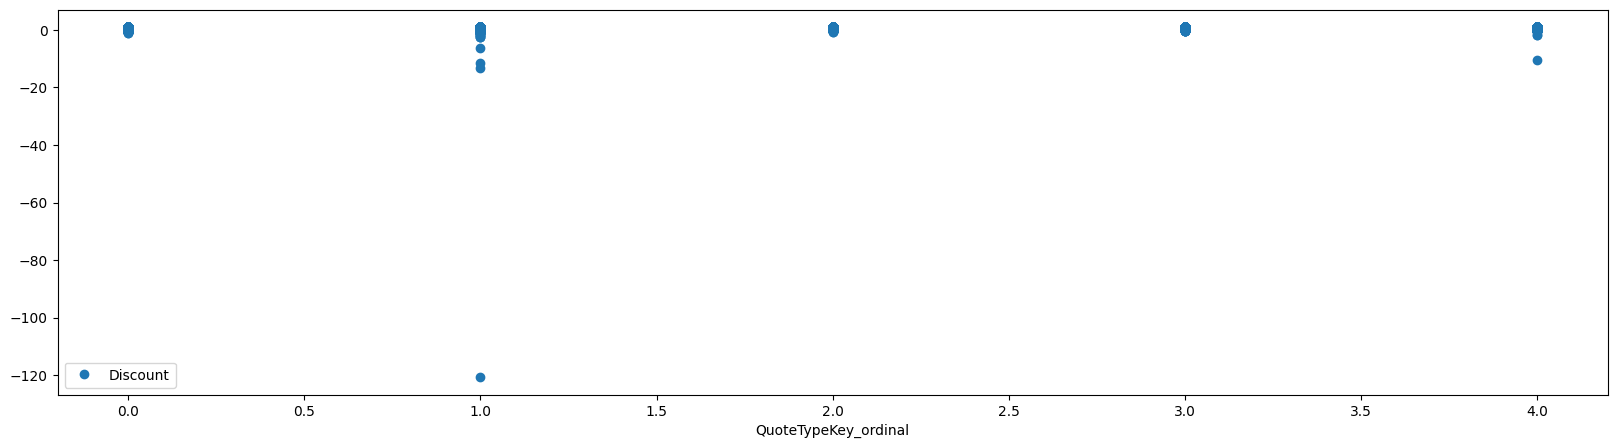

In [21]:
corr_pd.plot(x='QuoteTypeKey_ordinal', y='Discount', style='o', figsize=(20,5))

In [22]:
print(corr_pd['Discount'].max())
print(corr_pd['Discount'].min())

0.9997577043346202
-120.69514101214459


## Question 3
* Calculate ListPriceMarkup `ListPrice / Cost`
* Determine variables that explain higher ListPriceMarkup
* Determine variables that have a causal relationship with ListPrice

In [26]:
import pandas as pd

q3_df = pd.read_csv('case-study-fans.csv', delimiter='\t')
categorical_vars = ['Line', 'ProdId']
numerical_vars = ['Revenue', 'MarginPct', 'ListPrice', 'Cost', 'Volume']
q3_df = q3_df[categorical_vars + numerical_vars]
q3_df['ListPriceMarkup'] = q3_df.apply(lambda row: row.ListPrice / row.Cost, axis=1)

In [27]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
for column in categorical_vars:
    q3_df[column] = labelencoder.fit_transform(q3_df[column])

In [29]:
q3_df.corr()['ListPriceMarkup'][:]

Line               0.206497
ProdId             0.021371
Revenue           -0.058995
MarginPct          0.801781
ListPrice          0.649023
Cost              -0.131894
Volume            -0.010603
ListPriceMarkup    1.000000
Name: ListPriceMarkup, dtype: float64

## Question 4
* Calculate feature for expected ListPriceMarkup from other features
* Select a product with a big gap between ListPriceMarkup and expected ListPriceMarkup
* Calculate percent of products within 10% of expected ListPriceMarkup
* Using the causal variables create model that predicts difference in ListPrice and expected ListPrice
* Plot 1
    * shows ListPrice on y-axis, one variable (X) on x-axis, and another variable (color) that can take 3 values (represented by orange, green, blue). the vertical colored lines show that for a given value of X there are multiple ListPrices, and that Color progresses from one value to another as the ListPrice changes for that value of X
* Plot 2
    * Same for this plot with different y-axis
* Plot 3
    * results of model predicting ListPrice

In [33]:
q4_df = pd.read_csv('case-study-fans.csv', delimiter='\t')
categorical_vars = ['Line']
numerical_vars = ['Revenue', 'Volume', 'ListPriceMarkup']
q4_df['ListPriceMarkup'] = q4_df.apply(lambda row: row.ListPrice / row.Cost, axis=1)
q4_df = q4_df[categorical_vars + numerical_vars]

In [34]:
one_hot = pd.get_dummies(q4_df['Line'])
q4_df = q4_df.drop('Line', axis = 1)
q4_df = q4_df.join(one_hot)

In [36]:
from sklearn.linear_model import LinearRegression
X = q4_df.loc[:, q4_df.columns != 'ListPriceMarkup']
reg = LinearRegression().fit(X, q4_df['ListPriceMarkup'])

In [37]:

q4_df['ExpectedListPriceMarkup'] = reg.predict(X)

In [43]:
q4_df['ExpectedDiff'] = q4_df.apply(lambda row: (row.ListPriceMarkup - row.ExpectedListPriceMarkup) / row.ExpectedListPriceMarkup, axis=1)

In [44]:
print(q4_df['ExpectedDiff'].idxmax()) # 11982	30 Inch Canfield Fan
print(q4_df['ExpectedDiff'].idxmin())

77
112


In [45]:
q4_df.loc[q4_df.ExpectedDiff.between(-.1,.1), 'ExpectedDiff'].count() / len(q4_df)

0.4041095890410959

## ListPrice model

In [46]:
q4_df = pd.read_csv('case-study-fans.csv', delimiter='\t')
categorical_vars = ['Line']
numerical_vars = ['Revenue', 'Volume', 'Cost', 'ListPrice']
q4_df = q4_df[categorical_vars + numerical_vars]

In [47]:
one_hot = pd.get_dummies(q4_df['Line'])
q4_df = q4_df.drop('Line', axis = 1)
q4_df = q4_df.join(one_hot)

In [48]:
from sklearn.linear_model import LinearRegression
X = q4_df.loc[:, q4_df.columns != 'ListPrice']
reg = LinearRegression().fit(X, q4_df['ListPrice'])

In [62]:
reg.score(X, q4_df['ListPrice'])

0.5195622394547195

In [49]:
q4_df['ExpectedListPrice'] = reg.predict(X)

In [53]:
q4_df['ExpectedDiff'] = q4_df.apply(lambda row: (row.ListPrice - row.ExpectedListPrice) / row.ExpectedListPrice, axis=1)

In [51]:
print(q4_df['ExpectedDiff'].idxmax())
print(q4_df['ExpectedDiff'].idxmin())

20
112


In [54]:
q4_df.loc[q4_df.ExpectedDiff.between(-.1,.1), 'ExpectedDiff'].count() / len(q4_df)

0.5

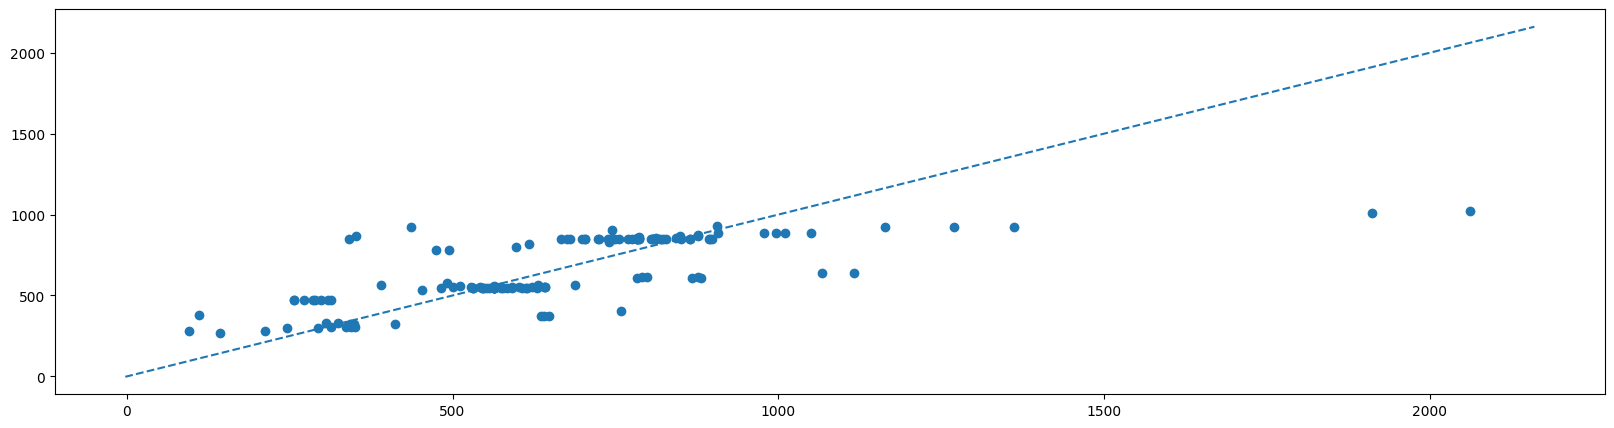

In [60]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(20,5))
plt.scatter(q4_df['ListPrice'], q4_df['ExpectedListPrice'])
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')

plt.show()

#q4_df.plot(x='ListPrice', y='ExpectedListPrice', style='o', figsize=(20,5))

## Ideas
If more time was given what could take the analysis to the next level?
* Better way to handle categorical features in Q1 and Q2, too many for one hot encoding. Find order for those that have it
* Time series analysis for Q1 and Q2
* NLP on product description to create features